In [1]:
# !pip install torch==2.2
!pip install torch
!pip install torchvision
!pip install seaborn
!pip install numpy
!pip install matplotlib
# !pip install torchsummary
# !pip install torchview
# !pip install graphviz
# !pip install torchviz
!pip install pandas
# !pip install efficientnet_pytorch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch.utils.data import random_split
import seaborn as sns
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
BATCH_SIZE = 64
num_epoch = 10
learning_rate = 1e-4
class_size = 10

In [6]:
# transform_train = transforms.Compose([transforms.Resize((224, 224)),
#                                       transforms.RandomHorizontalFlip(p=0.7),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# transform_test = transforms.Compose([transforms.Resize((224, 224)),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [7]:
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(p=0.7)])

transform_test = transforms.Compose([transforms.Resize((224, 224))])

In [8]:
!ls /content/drive/MyDrive/hurricane_damage/

QNN_TRAIN_CPU_hurricane_W4_X_S0_E10000_s1.npy	  QNN_TRAIN_CPU_hurricane_W4_XY_S0_E5000_s1.npy
QNN_TRAIN_CPU_hurricane_W4_X_S0_E10000_s2.npy	  QNN_TRAIN_CPU_hurricane_W4_XY_S5000_E10000_s1.npy
QNN_TRAIN_CPU_hurricane_W4_X_S0_E5000_s1.npy	  raw_hurricane_dataset
QNN_TRAIN_CPU_hurricane_W4_X_S5000_E10000_s1.npy  train_another_labels.npy
QNN_TRAIN_CPU_hurricane_W4_XY_S0_E10000_s1.npy


In [9]:
q_train_images = np.load("/content/drive/MyDrive/hurricane_damage/QNN_TRAIN_CPU_hurricane_W4_X_S0_E10000_s2.npy")


In [10]:
print(f'shape of raw quantum train data: {q_train_images.shape}')
train_output_shape = (4 * 10000, 64, 64, 3)
q_train_images = np.transpose(q_train_images, (4, 0, 1, 2, 3))
q_train_images = np.reshape(q_train_images, train_output_shape)
q_train_images = np.transpose(q_train_images, (0, 3, 1, 2))
print(f'shape of quantum train data: {q_train_images.shape}')

shape of raw quantum train data: (10000, 64, 64, 3, 4)
shape of quantum train data: (40000, 3, 64, 64)


In [11]:
torch.manual_seed(2024)

train_ref = torchvision.datasets.ImageFolder("/content/drive/MyDrive/hurricane_damage/raw_hurricane_dataset/train_another/", transform=transforms.ToTensor())
# train_ref_loader = DataLoader(train_ref, batch_size=1)

# labels = []
# for _, (_, label) in enumerate(train_ref_loader):
#   labels.append(label.item())

# print(len(labels))

val_size = 2000
train_size = len(train_ref) - val_size

train_ref, val_ref = random_split(train_ref, [train_size, val_size])

train_indices = train_ref.indices
val_indices = val_ref.indices

q_train_indices = train_indices + [10000 + x for x in train_indices] + [20000 + x for x in train_indices] + [30000 + x for x in train_indices]
q_val_indices = val_indices + [10000 + x for x in val_indices] + [20000 + x for x in val_indices] + [30000 + x for x in val_indices]

# train_loader_ref = DataLoader(train_ref, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
labels = np.load("/content/drive/MyDrive/hurricane_damage/train_another_labels.npy")
print(labels.shape)

(10000,)


In [13]:
transformed_labels = torch.Tensor(labels.tolist() * 4).to(torch.int64)
print(transformed_labels.shape)

torch.Size([40000])


In [14]:
train_dataset = TensorDataset(torch.Tensor(q_train_images), transformed_labels)

# val_size = 8000

# train_size = len(train_dataset) - val_size

train = Subset(train_dataset, q_train_indices)
val = Subset(train_dataset, q_val_indices)

# train, val = random_split(train_dataset, [train_size, val_size])

print(len(train))
print(len(val))

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

32000
8000


shape:  torch.Size([64, 3, 64, 64])
[0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


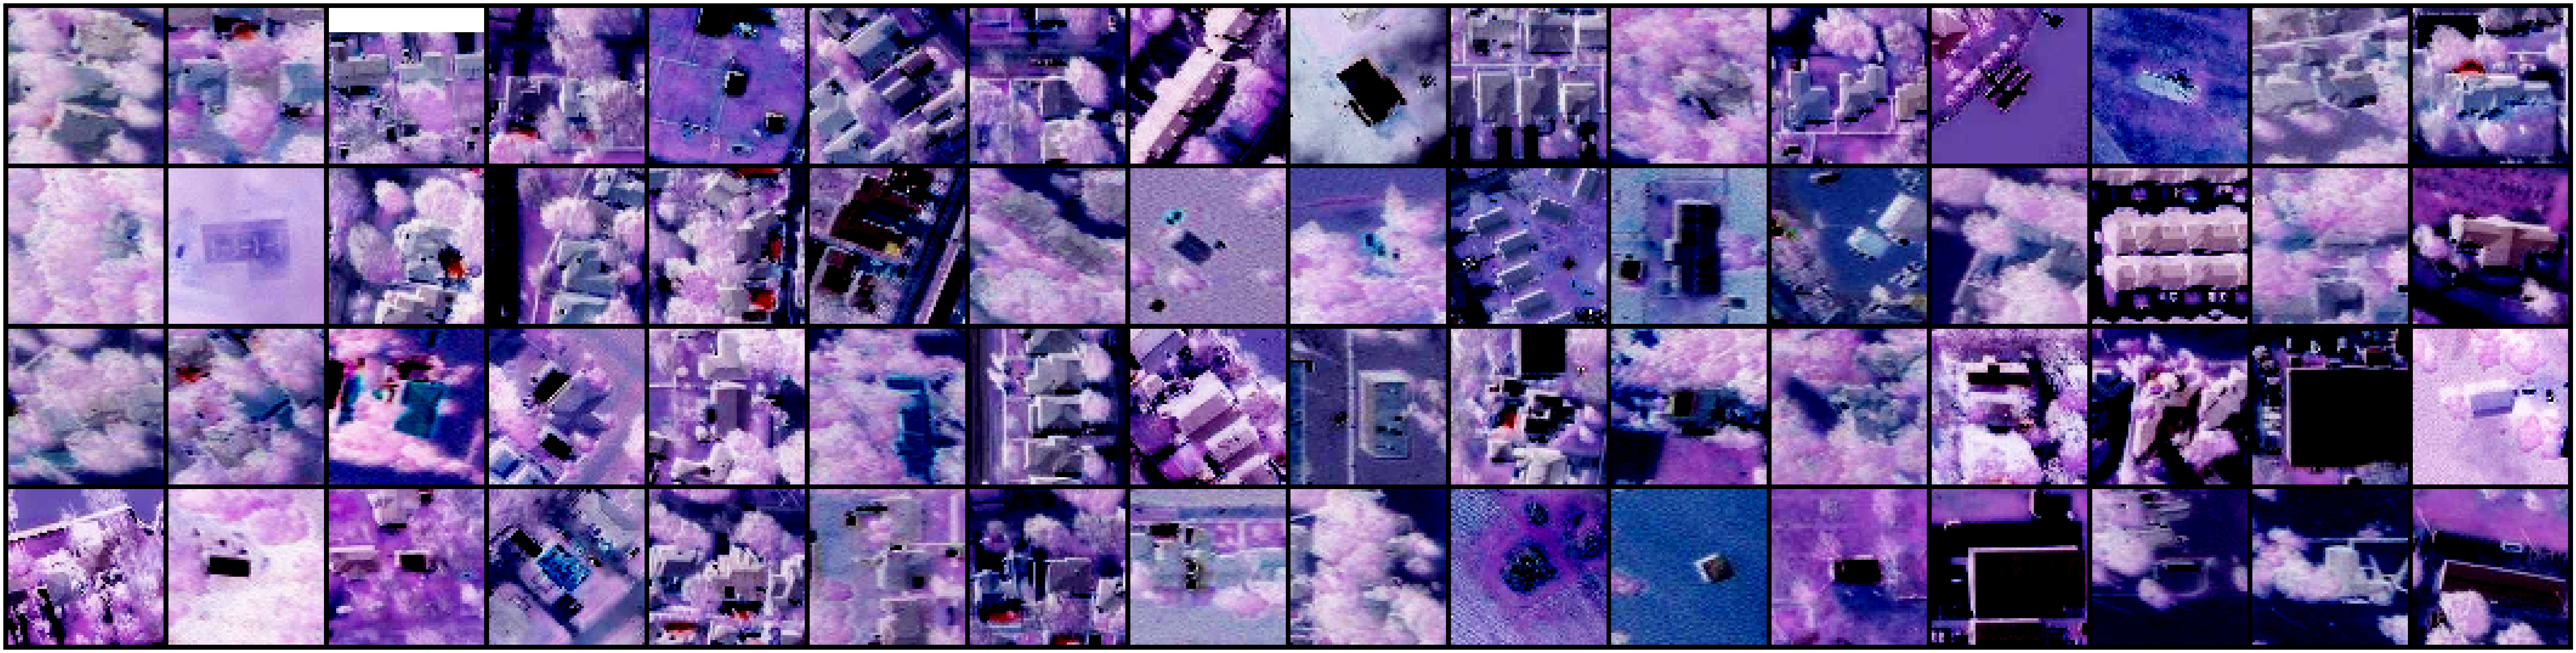

In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, labels in train_loader:
    print('shape: ', images.shape)
    print(labels.tolist())
    plt.figure(figsize=(100, 100))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [16]:
# import matplotlib.pyplot as plt
# from torchvision.utils import make_grid

# sub = Subset(train_dataset, [32000 + x for x in range(1000)])
# # 33000 - 35100, 38000 - 40000
# # 13000 - 15000, 18000 - 20000 ??
# # 20000 - 23000, 28000 - 29000 ???
# # for images, labels in train_loader:
# for images, labels in DataLoader(sub, batch_size=1000, shuffle=False):
#     print('shape: ', images.shape)
#     print(labels.tolist())
#     plt.figure(figsize=(100, 100))
#     plt.axis('off')
#     # plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
#     plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))
#     break

In [17]:
# import matplotlib.pyplot as plt
# from torchvision.utils import make_grid

# sub_ref = Subset(train_ref, [4990 + x for x in range(64)])

# for images, labels in DataLoader(sub_ref, batch_size=BATCH_SIZE, shuffle=False):
#     print('shape: ', images.shape)
#     print(labels.tolist())
#     plt.figure(figsize=(16, 8))
#     plt.axis('off')
#     # plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
#     plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
#     break

In [18]:
from torchvision import models

model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [19]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# from torchsummary import summary

# summary(model.cuda(), (3, 224, 224))

In [21]:
# from torchview import draw_graph

# model_graph = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True)
# model_graph.visual_graph

In [22]:
input_last_year = model.fc.in_features
model.fc = nn.Linear(input_last_year, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
epoch_loss_history = []
epoch_acc_history = []

In [24]:

# torch.cuda.empty_cache()

for epoch in range(num_epoch):
    epoch_avg_loss = 0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs = transform_train(imgs.to(device))
        labels = labels.to(device)

        labels_hat = model(imgs)
        n_corrects = (labels_hat.argmax(axis=1) == labels).sum().item()
        loss_value = criterion(labels_hat, labels)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_avg_loss += loss_value.item()

        accuracy = (n_corrects / labels.size(0)) * 100

        if (i+1) % 10 == 0:
            print(f'epoch {epoch + 1}/{num_epoch}, step: {i + 1}/{train_size/BATCH_SIZE}: loss = {loss_value:.5f}, acc = {accuracy:.2f}')

    epoch_loss_history.append(epoch_avg_loss / len(train_loader))

    with torch.no_grad():
        correct = 0
        samples = 0

        for i, (images, labels) in enumerate(test_loader):
            images = transform_test(images.to(device))
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = outputs.max(1)
            correct += (predictions == labels).sum()
            samples += predictions.size(0)

        accuracy = float(correct) / float(samples) * 100
        epoch_acc_history.append(accuracy)

        print(f"epoch {epoch + 1}/{num_epoch}, val accuracy = {accuracy:.2f}%. Correct {correct} out of {samples} samples")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch 1/10, step: 10/125.0: loss = 0.10086, acc = 96.88
epoch 1/10, step: 20/125.0: loss = 0.25061, acc = 93.75
epoch 1/10, step: 30/125.0: loss = 0.11898, acc = 95.31
epoch 1/10, step: 40/125.0: loss = 0.16983, acc = 92.19
epoch 1/10, step: 50/125.0: loss = 0.24606, acc = 85.94
epoch 1/10, step: 60/125.0: loss = 0.06582, acc = 96.88
epoch 1/10, step: 70/125.0: loss = 0.05021, acc = 96.88
epoch 1/10, step: 80/125.0: loss = 0.02886, acc = 98.44
epoch 1/10, step: 90/125.0: loss = 0.08507, acc = 98.44
epoch 1/10, step: 100/125.0: loss = 0.12678, acc = 92.19
epoch 1/10, step: 110/125.0: loss = 0.00899, acc = 100.00
epoch 1/10, step: 120/125.0: loss = 0.09726, acc = 96.88
epoch 1/10, step: 130/125.0: loss = 0.00774, acc = 100.00
epoch 1/10, step: 140/125.0: loss = 0.03843, acc = 98.44
epoch 1/10, step: 150/125.0: loss = 0.05778, acc = 98.44
epoch 1/10, step: 160/125.0: loss = 0.04051, acc = 98.44
epoch 1/10, step: 170/125.0: loss = 0.05114, acc = 96.88
epoch 1/10, step: 180/125.0: loss = 0.

In [25]:
print(epoch_loss_history)


[0.058801540464977736, 0.016483351025861338, 0.011922285971610108, 0.00672637408677474, 0.005498993457362303, 0.005096056770587893, 0.007254428669670233, 0.005064299343493985, 0.004671975988881968, 0.004969326995134906]


In [26]:
print(epoch_acc_history)


[96.26249999999999, 97.7375, 97.8125, 98.075, 97.6125, 98.375, 98.2375, 98.475, 97.95, 98.3375]


In [27]:
with open('/content/drive/MyDrive/res/history/resnet_hurricane_W4_x_s2_loss_history_val2.txt', "w") as f:
    for item in epoch_loss_history:
        f.write(f'{item:.5f}\n')

In [28]:
with open('/content/drive/MyDrive/res/history/resnet_hurricane_W4_x_s2_acc_history_val2.txt', "w") as f:
    for item in epoch_acc_history:
        f.write(f'{item:.5f}\n')

In [29]:
# import pandas as pd

# test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
# total_corrects =  0

# classes = set()

# for imgs, labels in test_loader:
#         for i in range(len(labels)):
#                 classes.add(labels[i])

# heatmap = pd.DataFrame(data=0, index=list(classes), columns=list(classes))

# with torch.no_grad():
#         for imgs, labels in test_loader:
#                 imgs = imgs.to(device)
#                 labels = labels.to(device)

#                 output = model(imgs)
#                 _, predicted = torch.max(output, 1)


#                 for i in range(labels.size(0)):
#                         if labels[i].item() == predicted[i].item():
#                                 total_corrects += 1

#                         heatmap.iloc[labels[i].item(), predicted[i].item()] += 1

# _, ax = plt.subplots(figsize=(10, 8))
# ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
# plt.show()

In [30]:
torch.save(model, '/content/drive/MyDrive/res/resnet_hurricane_W4_x_s2_val2.pth')